# Сборный проект-5

<p>Создание функции поиска фотографий по описанию для фотохостинга «Со Смыслом» (“With Sense”)<p>

## Описание задачи

<p>Нам поручено разработать демонстрационную версию поиска изображений по запросу.</p>
<p>Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.</p>

## Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).
<p>В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.</p>
<p>В папке `train_images` содержатся изображения для тренировки модели.</p>
<p>В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:</p>
<ul>
<li>Имя файла изображения.</li>
<li>Идентификатор описания.</li>
<li>Доля людей, подтвердивших, что описание соответствует изображению.</li>
<li>Количество человек, подтвердивших, что описание соответствует изображению.</li>
<li>Количество человек, подтвердивших, что описание не соответствует изображению.</li>
</ul>
<p>В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:</p>
<ul>
<li>Имя файла изображения.</li>
<li>Идентификатор описания.</li>
</ul>
<p>3, 4, 5 — оценки трёх экспертов.</p>
<p>Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.</p>
<p>В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.</p>
<p>В папке `test_images` содержатся изображения для тестирования модели.</p>

## Загрузка библиотек

In [81]:
!pip install wordcloud -q
!pip install torchvision -q
!pip install torchsummary -q
!pip install optuna -q
!pip install scikit-learn -q
!pip install "optuna-integration[sklearn]" -q
!pip install nltk -q
!pip install transformers -q
!pip install catboost -q
!pip install sentence_transformers -q

In [139]:
import pandas as pd
import re
import numpy as np
from math import ceil
from pathlib import Path

import pandas as pd

import time

import warnings

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import pickle
from collections import Counter

from sklearn.model_selection import GroupShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

from PIL import Image

import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import transforms
import torch.nn as nn
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torchsummary
from torchsummary import summary

from transformers import BertTokenizer, BertModel

from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
#from sklearn.decomposition import PCA

from catboost import CatBoostRegressor

from tqdm import tqdm

import sentence_transformers
from sentence_transformers import SentenceTransformer, util

import optuna
from optuna import distributions
from optuna.integration import OptunaSearchCV

[nltk_data] Downloading package wordnet to /Users/dima/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dima/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/dima/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Константы

<p>Объявим константы.</p>

In [2]:
# Начальное значение генератора случайных чисел
RANDOM_STATE = 12345

# Размер тестовой выборки
TEST_SIZE = 0.25

# Путь к данным
PATH = 'datasets/to_upload/'

# Путь к фотографиям обучающей выборки
PATH_TO_TRAIN_IMAGES = 'datasets/to_upload/train_images/'

# Путь к фотографиям тестовой выборки
PATH_TO_TEST_IMAGES = 'datasets/to_upload/test_images/'

# Слова для блокировки фотографий с детьми
BLOCK_WORDS = ['baby', 'toddler', 'kid', 'infant', 'boy', 'girl', 'teenager', 'child', 'adolescent', 'youngster']

# Текст сообщения для замещения фотографий с детьми
WARNING_TEXT = 'This image is unavailable in your country in compliance with local laws.'

## Загрузка данных

In [3]:
# Обучающие данные
df_train = pd.read_csv(PATH + 'train_dataset.csv')

# Тестовые данные
df_test_queries = pd.read_csv(PATH + 'test_queries.csv', sep='|')
df_test_images = pd.read_csv(PATH + 'test_images.csv')

# Оценки точности описаний на основе краудсорсинга
df_crowd_ann = pd.read_csv(PATH + 'CrowdAnnotations.tsv', sep='\t', 
                           names=['image', 'query_id', 'crowd_ratio', 'crowd_positive', 'crowd_negative'])

# Оценки точности на основе экспертных оценок
df_expert_ann = pd.read_csv(PATH + 'ExpertAnnotations.tsv', sep='\t', 
                            names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])

## Исследовательский анализ данных

<p>Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.</p>
<p>В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи мы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.</p>
<p>Мы можем воспользоваться другим методом агрегации оценок или придумать свой.</p>
<p>В файле с краудсорсинговыми оценками информация расположена в таком порядке:</p>
<ul>
<li>Доля исполнителей, подтвердивших, что текст <b>соответствует</b> картинке.</li>
<li>Количество исполнителей, подтвердивших, что текст <b>соответствует</b> картинке.</li>
<li>Количество исполнителей, подтвердивших, что текст <b>не соответствует</b> картинке.</li>
</ul>
<p>После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.</p>
<p>Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.</p>

### Анализ датафреймов

<p>Подготовим функцию определения наиболее часто встречающихся слов в тексте.</p>

In [4]:
# Функция возвращает наиболее часто встручающиеся слова в столбце датафрейма
def most_frequent_words(df, col):
    
    # Пример текста
    text = ' '.join(df_train['query_text'].astype(str))

    # Очистка текста от пунктуации
    cleaned_text = re.sub(r'[^\w\s]', '', text.lower())

    # Токенизация текста
    words = word_tokenize(cleaned_text)

    # Удаление стоп-слов
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]

    # Подсчёт частоты слов
    word_freq = nltk.FreqDist(filtered_words)

    # Вывод наиболее часто встречающихся слов
    most_common_words = word_freq.most_common(10)

    return pd.DataFrame(most_common_words, columns=['Слово', 'Частота'])

<p>Создадим функцию для вывода информации о датафрейме.</p>

In [5]:
# Функция выводит информацию о дотафрейме
def print_info(df, cols_uniq=[], cols_nuniq=[], cols_most_frequent=[]):

    print()
    
    # Выведем информацию о датафрейме
    print(df.info())
    print()
    
    # Выведем первые 5 строк датафрейма
    display(df.head(10))
    print()
    
    # Выведем размер датафрейма
    print('Размер датафрейма', df.shape)
    print()
    
    # Выведем число пропусков
    print('Количество пропусков:')
    print(df.isna().sum())
    print()
    
    # Выведем число дубликатов
    print('Количество дубликатов:')
    print(df.duplicated().sum())
    
    if cols_uniq:
        print()
        print('Уникальные значения в столбцах:')
        for col in cols_uniq:
            print(col, df[col].unique(), sep=' - ')
    
    if cols_nuniq:
        print()
        print('Количество уникальных значений в столбцах:')
        for col in cols_nuniq:
            print(col, df[col].nunique(), sep=' - ')

    if cols_most_frequent:
        print()
        print('Наиболее часто употребляемые слова:')
        for col in cols_most_frequent:
            print(col)
            display(most_frequent_words(df, col))

#### Обучающая выборка

In [6]:
# Выведем информацию о датафрейме
print_info(df_train, cols_nuniq=['image', 'query_id', 'query_text'], cols_most_frequent=['query_text'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None



,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
8,343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
9,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...



Размер датафрейма (5822, 3)

Количество пропусков:
image         0
query_id      0
query_text    0
dtype: int64

Количество дубликатов:
0

Количество уникальных значений в столбцах:
image - 1000
query_id - 977
query_text - 977

Наиболее часто употребляемые слова:
query_text


,Слово,Частота
0,dog,1161
1,man,996
2,two,841
3,white,697
4,woman,561
5,black,516
6,boy,511
7,wearing,450
8,water,440
9,girl,439


<ul>
    <li>В датафрейме 5822 строки, 3 столбца.</li>
    <li>Наименования столбцов корректны с точки зрения общепринятого стиля.</li>
    <li>Типы столбцов соответствуют находящимся в них данным.</li>
    <li>Пропусков данных и дубликатов не обнаружено.</li>
    <li>Число уникальных значений image равно 1000, число уникальных значений query_id и query_text равно 977.</li>
    <li>Учитывая отсутствие дубликатов, в датафрейме <b>5822 уникальных сочетаний фотографий и описаний</b>.</li>
    <li>Визуальный анализ query_id показывает, что в обучающей выборке содержатся описания к фотографиям под номером 2.</li>
    <li><b>Наиболее часто</b> в описаниях обучающей выборки <b>встречаются</b> (ТОП-5): <b>dog, man, two, white, woman</b>.</li>
</ul>

#### Тестовая выборка

In [7]:
# Выведем информацию о датафрейме
print_info(df_test_queries, cols_nuniq=['image', 'query_id', 'query_text'], cols_most_frequent=['query_text'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB
None



,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
5,5,1232148178_4f45cc3284.jpg#0,A baby girl playing at a park .,1232148178_4f45cc3284.jpg
6,6,1232148178_4f45cc3284.jpg#1,A closeup of a child on a playground with adul...,1232148178_4f45cc3284.jpg
7,7,1232148178_4f45cc3284.jpg#2,A young boy poses for a picture in front of a ...,1232148178_4f45cc3284.jpg
8,8,1232148178_4f45cc3284.jpg#3,A young girl is smiling in front of the camera...,1232148178_4f45cc3284.jpg
9,9,1232148178_4f45cc3284.jpg#4,There is a little blond hair girl with a green...,1232148178_4f45cc3284.jpg



Размер датафрейма (500, 4)

Количество пропусков:
Unnamed: 0    0
query_id      0
query_text    0
image         0
dtype: int64

Количество дубликатов:
0

Количество уникальных значений в столбцах:
image - 100
query_id - 500
query_text - 500

Наиболее часто употребляемые слова:
query_text


,Слово,Частота
0,dog,1161
1,man,996
2,two,841
3,white,697
4,woman,561
5,black,516
6,boy,511
7,wearing,450
8,water,440
9,girl,439


In [8]:
# Проверим, совпадают ли имена файлов фотографий в столбцах
df_test_queries['image'].equals(df_test_queries['query_id'].str[:-2])

True

<ul>
    <li>В датафрейме 500 строк, 3 столбца.</li>
    <li>Наименования столбцов корректны с точки зрения общепринятого стиля.</li>
    <li>Типы столбцов соответствуют находящимся в них данным.</li>
    <li>Пропусков данных и дубликатов не обнаружено.</li>
    <li>Количество уникальных значений image равно 100, query_id и query_text равно 500 (5 описаний для одной фотографии).</li>
    <li><b>Наиболее часто</b> в описаниях тестовой выборки <b>встречаются</b> слова (ТОП-5): <b>dog, man, two, white, woman</b>.</li>
    <li>В тестовой выборке имена файлов с фотографиями в столбце image совпадают именем файла, содержащемся в query_id.</li>
    <li>Таким образом, в тестовой выборке мы имеем <b>500 уникальных пар фотографий и соответствующих им описаний</b>.</li>
</ul>

In [9]:
# Удалим столбец, не содержащий нужной информации
df_test_queries = df_test_queries.drop('Unnamed: 0', axis=1)

In [10]:
# Выведем информацию о датафрейме
print_info(df_test_images, cols_nuniq=['image'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes
None



,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg
5,424307754_1e2f44d265.jpg
6,3044359043_627488ddf0.jpg
7,3396275223_ee080df8b5.jpg
8,2977379863_2e8d7a104e.jpg
9,634891010_9fa189effb.jpg



Размер датафрейма (100, 1)

Количество пропусков:
image    0
dtype: int64

Количество дубликатов:
0

Количество уникальных значений в столбцах:
image - 100


<ul>
    <li>В датафрейме 100 строк, 1 столбец.</li>
    <li>Наименование столбца корректно с точки зрения общепринятого стиля.</li>
    <li>Тип столбца соответствует находящимся в нем данным.</li>
    <li>Пропусков данных и дубликатов не обнаружено.</li>
    <li>Все <b>имена файлов</b> в тестовой выборке <b>уникальные</b>.</li>
</ul>

#### Оценки (краудсорсинг)

<p>Изучим данные по оценкам фотографий и описаний, полученным на основе краудсорсинга.</p>

In [11]:
# Выведем информацию о датафрейме
print_info(df_crowd_ann,
           cols_uniq=['crowd_positive', 'crowd_negative'],
           cols_nuniq=['image', 'query_id', 'crowd_positive', 'crowd_negative'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   crowd_ratio     47830 non-null  float64
 3   crowd_positive  47830 non-null  int64  
 4   crowd_negative  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None



,image,query_id,crowd_ratio,crowd_positive,crowd_negative
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,0,3
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,0,3
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,1,2
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,0,3
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,0,3



Размер датафрейма (47830, 5)

Количество пропусков:
image             0
query_id          0
crowd_ratio       0
crowd_positive    0
crowd_negative    0
dtype: int64

Количество дубликатов:
0

Уникальные значения в столбцах:
crowd_positive - [3 0 1 2 4 5]
crowd_negative - [0 3 2 1 4 5 6]

Количество уникальных значений в столбцах:
image - 1000
query_id - 1000
crowd_positive - 6
crowd_negative - 7


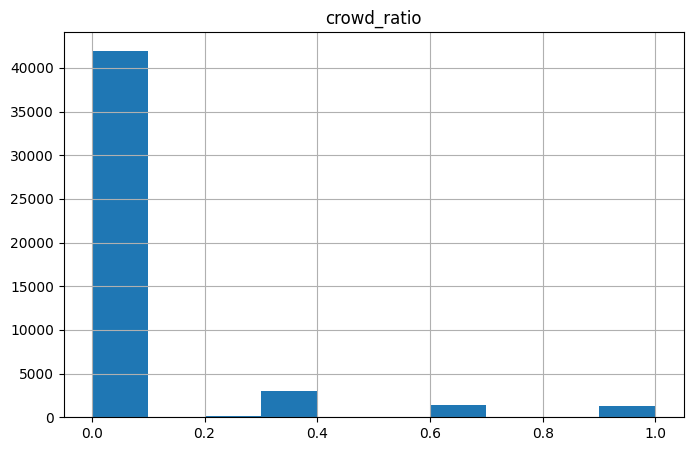

In [12]:
df_crowd_ann.hist(column=['crowd_ratio'], layout=(1, 1), figsize=(8, 5));

In [142]:
# Выведем число пар фотография-описание с crowd_ratio >= 0.6
relevant_pairs_1 = df_crowd_ann[df_crowd_ann['crowd_ratio'] >= 0.6]['crowd_ratio'].count()
relevant_pairs_0 = df_crowd_ann[df_crowd_ann['crowd_ratio'] < 0.2]['crowd_ratio'].count()

# Выведем характеристики распределения
print(f'Релевантны: {relevant_pairs_1}, не релевантны: {relevant_pairs_0}')

Релевантны: 2704, не релевантны: 41973


<ul>
    <li>В датафрейме 47830 строк, 5 столбцов.</li>
    <li>Наименования столбцов корректны с точки зрения общепринятого стиля.</li>
    <li>Типы столбцов соответствуют находящимся в них данным.</li>
    <li>Пропусков данных и дубликатов не обнаружено.</li>
    <li>Количество <b>уникальных</b> значений <b>image</b> и <b>query_id</b> равно <b>1000</b>.</li>
    <li>Уникальные значения crowd_positive - целые числа от 0 до 5 (6 значений).</li>
    <li>Уникальные значения crowd_negative - целые числа от 0 до 6 (7 значений).</li>
    <li>Учитывая отсутствие дубликатов, в датафрейме <b>47830 уникальных сочетаний фотографий и описаний</b>, оцененных при помощи <b>краудсорсинга</b>.</li>
    <li>Относительно высокая оценка сходства лишь у 2704 пар из 47830, а 41973 пар (87.8%) совсем не соответствуют друг другу. В датафрейме с оценками сходства на основе краудсорсинга <b>в большей степени представлены отрицательные примеры</b> (отсутствие сходства).</li>
</ul>

#### Оценки экспертов

In [14]:
# Выведем информацию о датафрейме
print_info(df_expert_ann,
           cols_uniq=['expert_1', 'expert_2', 'expert_3'],
           cols_nuniq=['expert_1', 'expert_2', 'expert_3'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB
None



,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2



Размер датафрейма (5822, 5)

Количество пропусков:
image       0
query_id    0
expert_1    0
expert_2    0
expert_3    0
dtype: int64

Количество дубликатов:
0

Уникальные значения в столбцах:
expert_1 - [1 2 3 4]
expert_2 - [1 2 3 4]
expert_3 - [1 2 3 4]

Количество уникальных значений в столбцах:
expert_1 - 4
expert_2 - 4
expert_3 - 4


In [15]:
# Создадим столбце со средней оценкой экспертов
df_expert_ann['expert_mean_norm'] = df_expert_ann.apply(lambda x: (x.expert_1 + x.expert_2 + x.expert_3 - 1)/(12 - 1), axis=1)

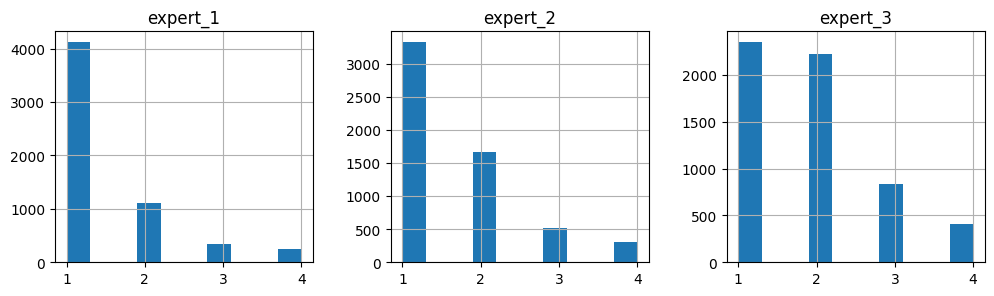

In [16]:
# Выведем распределение оценок экспертов
df_expert_ann.hist(column=['expert_1', 'expert_2', 'expert_3'], layout=(1, 3), figsize=(12, 3));

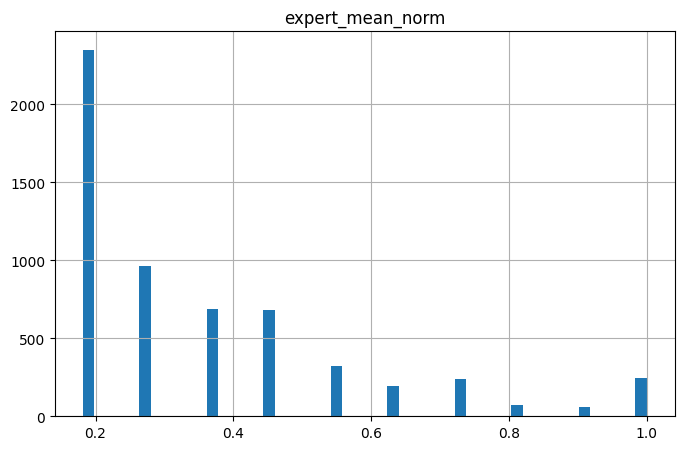

In [17]:
# Выведем распределение оценок экспертов
df_expert_ann.hist(bins=50, column=['expert_mean_norm'], layout=(1, 1), figsize=(8, 5));

In [143]:
relevant_pairs_1 = df_expert_ann[df_expert_ann['expert_mean_norm'] >= 0.6]['expert_mean_norm'].count()
relevant_pairs_0 = df_expert_ann[df_expert_ann['expert_mean_norm'] < 0.2]['expert_mean_norm'].count()

# Выведем характеристики распределения
print(f'Релевантны: {relevant_pairs_1}, не релевантны: {relevant_pairs_0}')

Релевантны: 816, не релевантны: 2350


<p>Произведем удаление ненужных столбцов.</p>

In [19]:
# Удаление столбцов
df_expert_ann = df_expert_ann.drop(['expert_1',	'expert_2',	'expert_3'], axis=1)

<ul>
    <li>В датафрейме 5822 строки, 5 столбцов.</li>
    <li>Наименования столбцов корректны с точки зрения общепринятого стиля.</li>
    <li>Типы столбцов соответствуют находящимся в них данным.</li>
    <li>Пропусков данных и дубликатов не обнаружено.</li>
    <li>Уникальные значения в столбцах expert_1, expert_2, expert_3 - целые числа от 1 до 4 (4 значения).</li>
    <li>Учитывая отсутствие дубликатов, в датафрейме <b>5822 уникальных сочетаний фотографий и описаний</b>, оцененных <b>экспертами</b>.</li>
    <li>Лишь незначительная часть фотографий и описаний, по оценкам экспертов, в точности соответствует соответствуют друг другу (средняя оценка 4).</li>
    <li>При этом <b>оценки в районе 2 и 3</b> в случае с экспертными оценками <b>также имеют значимость</b> для нас, поскольку говорят о том, что описание в большей или меньшей степени содержит элементы изображения.</li>
    <li>Относительно высокая оценка сходства у 816 пар из 5822, а 2350 пар (40%) совсем не соответствуют друг другу. В остальных парах есть в большее или меньшее число сходных деталей на фотографиях и в описаниях. Датафрейм с оценками сходства на основе ответов экспертов <b>в большей сбалансирован по степени релевантности</b>.</li>
</ul>

### Уникальность фото и описаний в выборках

<p>Проверим списки фотографий в тестовой и обучающей выборках на предмет пересечения.</p>

In [20]:
def get_common_values(df1, df2, cols=[]):
    for col in cols:
        # Ищем общие значения в столбце 'image'
        common_values = pd.merge(df1, df2, on=col, how='inner')
        num = len(common_values)
        if num == 0:
            print(col, 'Общих значений не найдено.', sep=' - ')
        else:
            print(col, f'Число общих значений {num}.', sep=' - ')

In [21]:
# Ищем общие значения в столбцах
get_common_values(df_train, df_test_queries, ['image', 'query_text'])

image - Общих значений не найдено.
query_text - Общих значений не найдено.


<ul>
    <li>В обучающей и тестовой выборках нет одинаковых фотографий (пересечений не обнаружено).</li>
    <li>В обучающей и тестовой выборках нет одинаковых описаний.</li>
</ul>

### Примеры фотографий

In [22]:
# Функция выводит случайные фотографии из выборки
def show_photos(df, col, path):
    fig = plt.figure(figsize=(10,10))
    for i, file_name in enumerate(df.sample(n=12)[col]):
        fig.add_subplot(3, 4, i+1)
        image = Image.open(path + file_name) 
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

#### Обучающая выборка

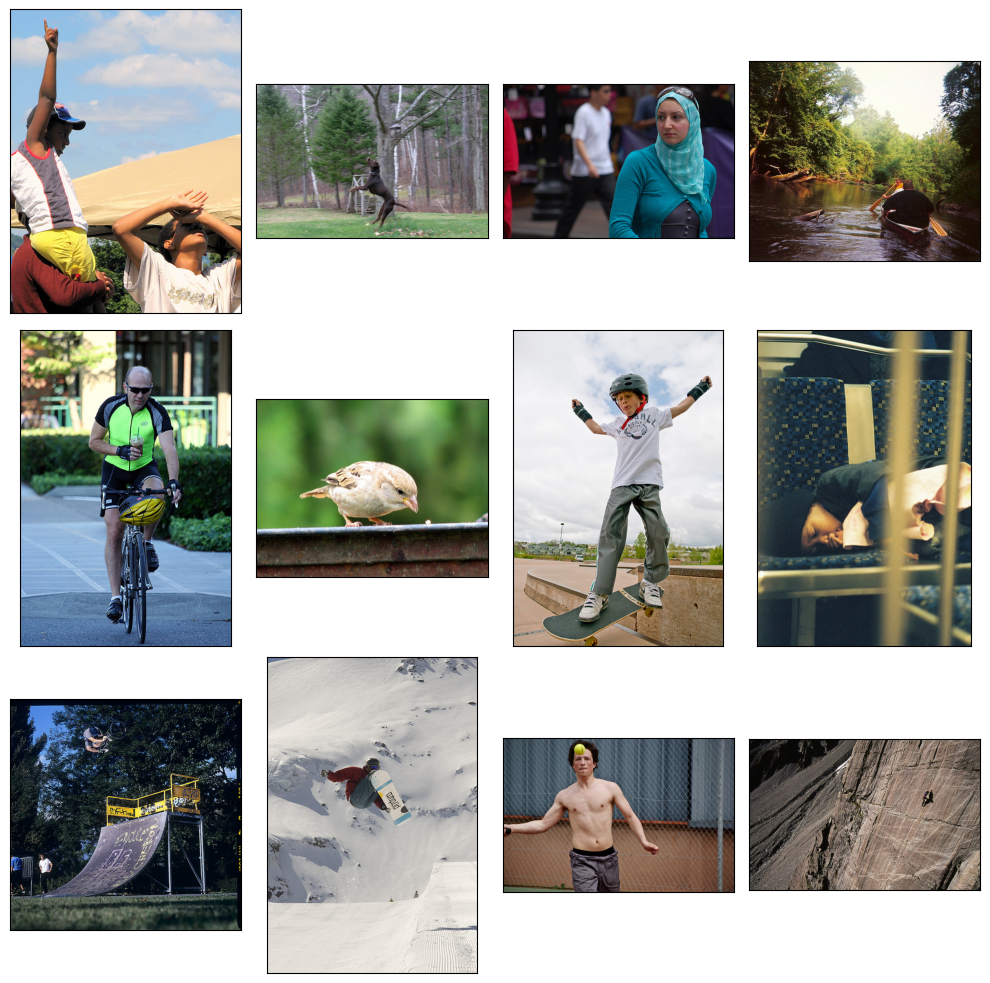

In [23]:
# Фотографии из обучающей выборки
show_photos(df_train, 'image', PATH_TO_TRAIN_IMAGES)

#### Тестовая выборка

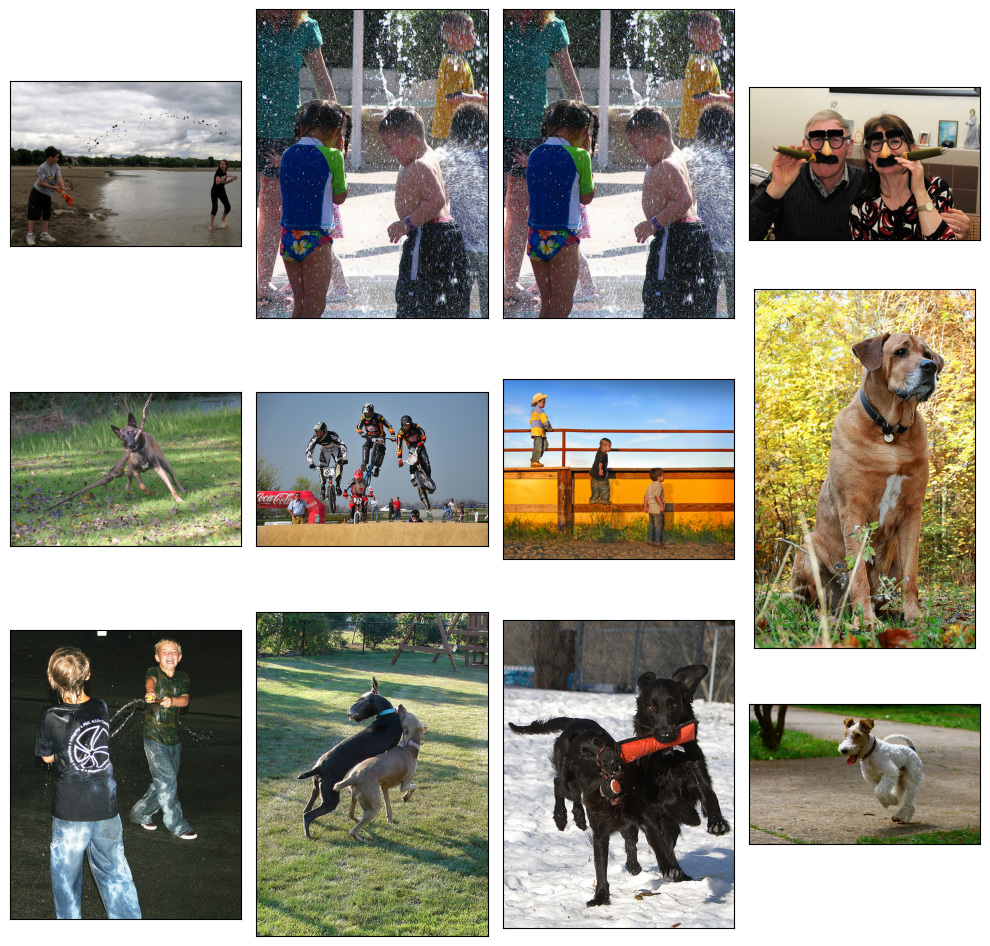

In [24]:
# Фотографии из тестовой выборки
show_photos(df_test_queries, 'image', PATH_TO_TEST_IMAGES)

## Выводы

<ul>
    <li>Датафреймы проверены на пропуски, дубликаты, корректность наименований столбцов и типов данных.</li>
    <li>В обучающей выборке <b>1000 уникальных фотографий и 977 уникальных описаний и идентификаторов описаний</b>.</li>
    <li>В тестовой выборке <b>500 уникальных пар фотографий и соответствующих им описаний</b>.</li>
    <li>В тестовой выборке имена файлов с фотографиями в столбце image совпадают именем файла, содержащемся в query_id.</li>
    <li>Наиболее часто в описаниях обеих выборок встречаются (ТОП-5): <b>dog, man, two, white, woman</b>. Это косвенно свидетельствует от том, что <b>выборки структурно похожи</b> (встречаемость объектов на фотографиях близка). Это важно для корректного тестирования обученной модели.</li>
    <li>В датафрейме с оцененками <b>экспертов 5822 уникальных сочетаний фотографий и описаний</b>.</li>
    <li>В датафрейме с оцененками на основе <b>краудсорсинга 47830 уникальных сочетаний фотографий и описаний</b>.</li>
    <li>В датафрейме с <b>оценками краудсорсинга в значительной степени представлены не соответсвующие друг другу пары</b> фотография-описание (оценки краудсорсинга не имеют промежуточных градаций соответствия).</li>
    <li>Датафрейм с <b>ответами экспертов более сбалансирован по оценкам</b> сходства за счет наличия градаций соответствия.</li>
    <li>На выведенных фотографиях <b>есть дети</b>. Для соблюдения требований закона некоторых стран, где будет использоваться данный сервис, нам будет нужно вместо такой фотографии <b>выводить заглушку с предупреждением</b>.</li>
</ul>

# Объединение данных

<p>Используем для обучения моделей оценки экспертов.</p>
<p>Выбор оценок экспертов обусловлен несколькими причинами:</p>
<ul>
    <li>Оценка эксперта содержит дополнительную информацию помимо 'соответствует' или 'не соответсnвует' описание изображению (возможны промежуточные состояния, когда в описании верно указаны какие-либо из элементов или деталей). Оценки краудсорсинга такой информации не содержат, а датафрейм с оценкми краудсорсинга в значительной степени представлен отрицательными примерами.</li>
    <li>Вероятно, эксперты более ответственно оценивают степень соответствия описания запросу.</li>
</ul>
<p>Более высокое качество тренировочных данных выборки должно компенсировать очевидный недостаток данного подхода - меньшую по размеру обучающую выборку (чем если бы мы дополнительно использовали оценки краудсорсинга). Вероятно, этот недостаток будет скомпенсирован более содержательным по смыслу таргетом.</p>
<p>Объединим тестовую выборку с датафреймом с оценками экспертов. Для объединения используем пары image-query_id, в итоге мы получим для каждой пары изображение-описание оценки экспертов.</p>

In [25]:
# Создадим объединенную выборку
df_merged = pd.merge(df_expert_ann, df_train, on=['image', 'query_id'], how='inner')

<p>Проверим размер созданной выборки и пропуски.</p>

In [26]:
# Размер объединенной выборки
df_merged.shape

(5822, 4)

In [27]:
# Выведем число пропусков
df_merged.isna().sum()

image               0
query_id            0
expert_mean_norm    0
query_text          0
dtype: int64

<p>В объединенной выборке такое же число строк, как и в обучающей выборке, пропусков в данных нет. Таким образом, <b>для каждой пары изображение-описание добавлены средние оценки экспертов</b>.</p>
<p>Выведем объединенный датафрейм для ознакомления.</p>

In [28]:
# Выведем первые 5 строк датафрейма
df_merged.head()

,image,query_id,expert_mean_norm,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.181818,A young child is wearing blue goggles and sitt...
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.272727,A girl wearing a yellow shirt and sunglasses s...
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.272727,A man sleeps under a blanket on a city street .
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.363636,A woman plays with long red ribbons in an empt...
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.272727,Chinese market street in the winter time .


## 2. Проверка данных

В некоторых странах, где работает  наша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно будет удалить из обучающей выборки.

<p>Подготовим функцию для очистки и лемматизации текста.</p>

In [29]:
# Функция производит очистку, токенизацию и лемматизацию текста
def lem_text(text):

    text = text.lower()

    # Удаление специальных символов (все, кроме букв и пробелов)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Замена нескольких пробелов на один
    text = re.sub(r'\s+', ' ', text).strip()

    # Токенизируем слова
    text = nltk.word_tokenize(text, language = 'english')

    # Инициализация лемматизатора
    lem = WordNetLemmatizer()

    # Лемматизация каждого слова в тексте
    lem_words = [lem.lemmatize(word, 'v') for word in text]

    # Убираем стоп-слова
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in lem_words if word not in stop_words]

    return filtered_words

<p>Пометим фотографии, в описании которых есть слова из списка блокировки.</p>

In [30]:
# Создадим столбец с признаком блокировки по контенту
df_merged['block'] = df_merged.apply(lambda x: 1 if len(set(lem_text(x.query_text)) & set(BLOCK_WORDS)) > 0 else 0, axis=1)

<p>Выведем 10 случайных фотографий и описаний к ним с признаком блокировки для проверки перед удалением.</p>

In [31]:
# Датафрейм с фотографиями
df = df_merged[df_merged['block'] == 1].sample(10)

# Выводим фотографии с описаниями
for index, row in df.iterrows():
    img = PATH_TO_TRAIN_IMAGES + row['query_id'][:-2]
    display(HTML(f'''<div style="display: flex;">
                    <div><img src="{img}" style="width: 250px; margin-right:20px;"/></div>
                    <div>{row["query_text"]}</div>
                  </div>'''))

<p>На выведенных фотографиях есть дети, маркировка произведена верно.</p>
<p>Удалим помеченные фотографии.</p>

In [32]:
#Удаление фотографий с признаком блокировки
df_merged = df_merged[df_merged['block'] != 1]

In [33]:
# Проверим объем тестовой выборки после удаления
df_merged.shape

(4588, 5)

<p>Объем датафрейма сократился <b>с 5822</b> до <b>4588</b>.</p>
<p>Произведем даление столбца с признаком блокировки.</p>

In [34]:
# Удалим столбец
df_merged = df_merged.drop('block', axis=1)

In [35]:
# Пересчитаем индексы
df_merged.reset_index(inplace=True)

In [36]:
# Создадим столбец с векторами изображений
df_merged['query_text_lemmatize'] = df_merged['query_text'].apply(lambda x: lem_text(x))

## Вывод

<ul>
   <li>Произведена очистка обучающей выборки от фотографий с детьми.</li>
    <li>Объем датафрейма сократился с <b>с 5822</b> до <b>4588</b>.</li>
</ul>

## 3. Векторизация изображений

<p>Перейдём к векторизации изображений.</p>
<p>Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений.</p>
<p>Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.</p>
<p>В задании говорится "Сделайте векторизацию изображений с использованием модели ResNet50 из библиотеки Keras или PyTorch", поэтому используем архитектуру ResNet50.</p>

In [39]:
# Загружаем претренированную модель ResNet50
resnet = models.resnet50(pretrained=True)

# Заморозим веса
for param in resnet.parameters():
    param.requires_grad_(False)

# Выведем список слоев
display(list(resnet.children()))

# Выведем summary
summary(resnet, (3, 224, 224))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<p>Используем <b>последний сверточный слой</b> для получения эмбеддингов (четвертый Sequential, в нем третий Bottleneck, в нем <b>(conv3)</b>).</p>
<p>Его размерность <b>[-1, 2048, 7, 7]</b>.</p>
<p>Для извлечения данных с этого слоя <b>используем хук</b>. Для этого определим функцию извлечения выходных данных с нужного слоя прямом проходе по сети.</p>

In [40]:
# Определяем хук для извлечения выходных данных из последнего сверточного слоя
def hook_function(module, input, output):
    
    # Объявляем глобальную переменную, в которой будут сохранены выходы с нужного слоя
    global conv_output
    
    # Сохраняем выходы со слоя
    conv_output = output

# Используем последний блок Sequential
last_bottleneck = resnet.layer4[-1]

# Слой conv2 с последнего Bottleneck
second_to_last_conv_layer = last_bottleneck.conv3

# Выход с предпоследнего сверточного слоя
second_to_last_conv_layer.register_forward_hook(hook_function)

# Создадим препроцессор для ресайза, кропа, преобразования в тензор и нормализации
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

In [59]:
# Функция для создания векторов изображений
def vect_image(file_name, path, model, preprocess):

    # Загружаем изображение
    img = Image.open(path + file_name).convert('RGB')

    # Преобразовываем изображение
    image_tensor = preprocess(img)

    # Добавляем размерность batch_size
    image_tensor = image_tensor.unsqueeze(0) 
    
    # Выполним проход по сети
    model(image_tensor)

    # Проведем усреднение по пространственным размерам (7x7) тензора torch.Size([1, 2048, 7, 7])
    # Возвращаем выход с нужного слоя сети в виде одномерного вектора
    return conv_output.mean(dim=[2, 3]).squeeze()

In [60]:
%%time

resnet.eval()

# Создадим столбец с векторами изображений
df_merged['image_vect'] = df_merged.apply(lambda x: vect_image(x.image, PATH_TO_TRAIN_IMAGES, resnet, preprocess), axis=1)

CPU times: user 3min 49s, sys: 27.8 s, total: 4min 17s
Wall time: 2min 34s


In [61]:
# Функция для получения длины массива
def get_length(array):
    return len(array)

# Применение функции к каждому элементу столбца
lengths = df_merged['image_vect'].apply(get_length)

# Получение минимальной и максимальной длины
min_length = lengths.min()
max_length = lengths.max()

print(f'Минимальная длина вектора {min_length}, максимальная длина вектора {max_length}')

Минимальная длина вектора 2048, максимальная длина вектора 2048


## Вывод

<ul>
    <li>Создан <b>столбец с векторами изображений</b>.</li>
    <li>Размерность выходы последнего сверточного слоя равна [-1, 2048, 7, 7]. Это соответствует 2048 картам признаков (каналов), размер выходного тензора 7 на 7. Итоговый вектор равен 2048</b>. Это свидетельствует от том, что <b>мы выбрали правильный слой</b> для получения вектора изображения.</li>
    <li>Для нас важно, что вектор получен со сверточного слоя фиксированной размерности, в результате мы получаем <b>векторы изображений одинакового размера</b>. Вектор содержит главные 'компоненты' изображения, при этом <b>размер вектора существенно уменьшен</b> по сравнению с размером исходного изображения.</li>
</ul>

## 4. Векторизация текстов

<p>Следующий этап — векторизация текстов. Мы можем поэкспериментировать с несколькими способами векторизации текстов:</p>
<ul>
<li>tf-idf</li>
<li>word2vec</li>
<li>\*трансформеры (например Bert)</li>
</ul>

\* — <i>если вы изучали трансформеры в спринте Машинное обучение для текстов.</i>

<p>Для создания векторов для описаний <b>используем модель BERT</b>.</p>

In [62]:
# Загрузка токенизатора
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Загрузка модели BERT
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [63]:
# Выведем список слоев
display(list(bert_model.children()))

[BertEmbeddings(
   (word_embeddings): Embedding(30522, 768, padding_idx=0)
   (position_embeddings): Embedding(512, 768)
   (token_type_embeddings): Embedding(2, 768)
   (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   (dropout): Dropout(p=0.1, inplace=False)
 ),
 BertEncoder(
   (layer): ModuleList(
     (0-11): 12 x BertLayer(
       (attention): BertAttention(
         (self): BertSdpaSelfAttention(
           (query): Linear(in_features=768, out_features=768, bias=True)
           (key): Linear(in_features=768, out_features=768, bias=True)
           (value): Linear(in_features=768, out_features=768, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
         )
         (output): BertSelfOutput(
           (dense): Linear(in_features=768, out_features=768, bias=True)
           (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
           (dropout): Dropout(p=0.1, inplace=False)
         )
       )
       (intermediate): BertInterme

<p>Для векторизации описаний используем выход из последнего скрытого слоя.</p>
<p>Размерность полученного вектора будет равна <b>768</b>.</p>
<p>Предварительно отфильтруем описания, оставив только слова с TF-IDF выше пороговой.</p>

In [64]:
# Функция для вычисления TF-IDF
def compute_tfidf(texts):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    return tfidf_matrix, feature_names

def filter_text_by_tfidf(text, tfidf_matrix, feature_names, doc_number, min_tfidf=0.1):

    # Создаём словарь для хранения весов TF-IDF каждого слова
    word_tfidf = {}

    # Проходим по всем словам в тексте
    for word in text:
        if word in feature_names:
            # Находим индекс слова в списке feature_names
            index = np.where(feature_names == word)[0][0]

            # Получаем вес TF-IDF слова из матрицы
            tfidf_weight = tfidf_matrix[doc_number, index]

            # Сохраняем вес слова
            word_tfidf[word] = tfidf_weight

    # Фильтруем слова по минимальному порогу TF-IDF
    filtered_words = [word for word, weight in word_tfidf.items() if weight >= min_tfidf]

    return filtered_words

# Функция для векторизации описаний
def vect_text_with_tfidf(text, model, max_length, tfidf_matrix, feature_names, doc_number):

    # Оставляем стова с tfidf больше порогового значения
    filtered_text = filter_text_by_tfidf(text, tfidf_matrix, feature_names, doc_number, 0.34)

    # Преобразуем из списка в строку
    filtered_text = " ".join(filtered_text)
    
    # Токенизация текста
    inputs = tokenizer(filtered_text, return_tensors="pt", padding='max_length', max_length=max_length)

    # Получение векторов
    with torch.no_grad():
        outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    
    # Получаем выход с последнего скрытого слоя
    embeddings = outputs.last_hidden_state

    # Проводим пулинг по первому измерению и выпрямляем в одномерный вектор
    pooled_embedding = embeddings.mean(dim=1).numpy().squeeze()

    return pooled_embedding

# Создаем корпус текстов
texts = [' '.join(words) for words in df_merged['query_text_lemmatize']]
tfidf_matrix, feature_names = compute_tfidf(texts)

In [65]:
%%time

# Создадим столбец с векторами описаний
df_merged['query_text_vect'] = df_merged.apply(
    lambda x: vect_text_with_tfidf(x.query_text_lemmatize, bert_model, 512, tfidf_matrix, feature_names, x.name), axis=1
)

CPU times: user 24min 59s, sys: 1min 48s, total: 26min 48s
Wall time: 13min 58s


In [66]:
# Применение функции к каждому элементу столбца
lengths = df_merged['query_text_vect'].apply(get_length)

# Получение минимальной и максимальной длины
min_length = lengths.min()
max_length = lengths.max()

print(f'Минимальная длина вектора {min_length}, максимальная длина вектора {max_length}')

Минимальная длина вектора 768, максимальная длина вектора 768


## Вывод
<ul>
    <li>Создан столбец с векторами описаний.</li>
    <li>Длина векторов одинакова для всех описаний.</li>
</ul>

## Объединение векторов

<p>Подготовим данные для обучения: объединим векторы изображений и векторы текстов с целевой переменной.</p>

In [67]:
#with open('df_merged_2048.pickle', 'wb') as f:
#    pickle.dump(df_merged, f)

#with open('df_merged.pickle', 'rb') as f:
#    df_merged = pickle.load(f)

# Создадим массивы numpy из столбцов в векторами описаний и изображений
embeds_txt = np.vstack(df_merged['query_text_vect'].to_numpy())
embeds_img = np.vstack(df_merged['image_vect'].to_numpy())

# Приведем данные к одному формату (в embeds_img сейчас float32) 
embeds_img = embeds_img.astype(np.float64)

# Создадим признаки и таргет
X = np.concatenate((embeds_img, embeds_txt), axis=1)
y = df_merged['expert_mean_norm']

print("Форма данных X:", X.shape)

Форма данных X: (4588, 2816)


## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберем самостоятельно. Также нам предстоит выбрать метрику качества либо реализовать свою.

In [68]:
# Разделим данные на обучающую и валидационную выборки с учётом групп
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)

# Получим индексы выборок
train_indices, val_indices = next(gss.split(X=X, y=y, groups=df_merged['image']))

# Создадим выборки с фичами для обучения и валидации
X_train, X_val = X[train_indices], X[val_indices]

# Создадим таргеты для обучения и валидации
y_train, y_val = y[train_indices], y[val_indices]

print(f'Обучающая выборка: {X_train.shape}, Валидационная выборка: {X_val.shape}')

Обучающая выборка: (3223, 2816), Валидационная выборка: (1365, 2816)


## Масштабирование признаков

In [69]:
# Масштабирование не проводилось

# Объявим скалер, обучим на тренировочных фичах
#scaler = StandardScaler().fit(X_train)

# Проведем масштабирование признаков обучающей выборки
#X_train = scaler.transform(X_train)

# Проведем масштабирование признаков валидационной выборки
#X_val = scaler.transform(X_val)

#X_train.shape

## Выводы

<ul>
    <li>Данные <b>разделены на обучающую и валидационную</b> выборки.</li>
    <li>Проведены тесты с обучением моделей с масштабированием и без масштабирования. Предварительное <b>масштабирование не оказало влияния на точность моделей</b>.</li>
</ul>

### Обучение моделей

<p>Проведем обучение нескольких моделей (LinearRegression, CatBoostRegressor, нейросеть) на тренировочных данных с <b>вычислением метрики на кросс-валидации</b> (кроме нейросети).</p>
<p>Вычислим <b>метрику на валидационной выборке</b>.</p>
<p>В качестве метрики <b>используем RMSE</b>, которая позволит интерпретировать результаты обучения.</p>
<p>По результатам обучения <b>выберем лучшую модель</b>.</p>

#### LinearRegression

In [70]:
%%time

# Объявляем модель
lr_model = LinearRegression(n_jobs=-1)

# Обучаем модель на тренировочных данных
lr_model.fit(X_train, y_train)

# Посчитаем метрику rmse на кросс-валидции
score = cross_val_score(lr_model,
                        X_train, y_train,
                        groups=df_merged['image'].loc[train_indices],
                        scoring='neg_root_mean_squared_error',
                        cv=GroupShuffleSplit(n_splits=3, random_state=RANDOM_STATE)
                        ).mean()

# Выведем метрику модели на кросс-валидации
print('RMSE модели на кросс-валидации: ', round(abs(score), 4))

# Выполним предсказание на валидационной выборке
pred = lr_model.predict(X_val)

# Вычислим метрику модели на валидационной выборке
rmse_score = np.sqrt(mean_squared_error(y_val, pred))

# Выведем метрику на валидации
print('RMSE модели на валидации: ', round(rmse_score, 4))

RMSE модели на кросс-валидации:  0.5487
RMSE модели на валидации:  0.3515
CPU times: user 1min 5s, sys: 3.83 s, total: 1min 9s
Wall time: 18.5 s


#### CatBoostRegressor

In [136]:
%%time

# Параметры для поиска
params = {
          'iterations': [50, 100, 150, 200],
          'learning_rate': [0.01, 0.05, 0.1],
          'depth': [2, 4, 6, 8]
         }

# Инициализируем модель
catboost = CatBoostRegressor(verbose=0)

# Инициализируем RandomizedSearch
rscv = RandomizedSearchCV(catboost,
                          params,
                          cv=GroupShuffleSplit(n_splits=3, random_state=RANDOM_STATE),
                          scoring='neg_root_mean_squared_error',
                          random_state=RANDOM_STATE,
                          n_jobs=1,
                          n_iter=20,
                          verbose=2)

# Произведем обучение
catboost_model = rscv.fit(X_train, y_train, groups=df_merged['image'].loc[train_indices])

print('RMSE лучшей модели: ', round(-1*catboost_model.best_score_, 2))

pred = catboost_model.predict(X_val)

rmse_score_val = round(np.sqrt(mean_squared_error(y_val, pred)), 4)

print('RMSE на валидации: ', round(rmse_score_val, 2))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END .........depth=6, iterations=200, learning_rate=0.1; total time=  50.3s
[CV] END .........depth=6, iterations=200, learning_rate=0.1; total time=  42.6s
[CV] END .........depth=6, iterations=200, learning_rate=0.1; total time=  43.4s
[CV] END ........depth=4, iterations=200, learning_rate=0.01; total time=  16.8s
[CV] END ........depth=4, iterations=200, learning_rate=0.01; total time=  17.2s
[CV] END ........depth=4, iterations=200, learning_rate=0.01; total time=  16.1s
[CV] END .........depth=4, iterations=50, learning_rate=0.01; total time=   6.6s
[CV] END .........depth=4, iterations=50, learning_rate=0.01; total time=   6.4s
[CV] END .........depth=4, iterations=50, learning_rate=0.01; total time=   6.3s
[CV] END ........depth=6, iterations=100, learning_rate=0.05; total time=  23.3s
[CV] END ........depth=6, iterations=100, learning_rate=0.05; total time=  22.5s
[CV] END ........depth=6, iterations=100, learni

#### Нейросеть

In [124]:
# Функция создания сети
def init_nn(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons=1, dropout_rate=0.5):

    class RegressionModel(nn.Module):
        def __init__(self):
            super(RegressionModel, self).__init__()
            self.fc1 = nn.Linear(in_features=n_in_neurons, out_features=n_hidden_neurons_1)
            self.relu = nn.LeakyReLU()
            self.dropout1 = nn.Dropout(p=dropout_rate)
            self.fc2 = nn.Linear(in_features=n_hidden_neurons_1, out_features=n_hidden_neurons_2)
            self.fc3 = nn.Linear(in_features=n_hidden_neurons_2, out_features=n_hidden_neurons_3)
            self.fc4 = nn.Linear(in_features=n_hidden_neurons_3, out_features=n_out_neurons)

            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
            self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)

            # Инициализация весов
            self.initialize_weights()

        def forward(self, x):

            x = self.fc1(x)
            #x = self.bn1(x)
            x = self.relu(x)
            x = self.dropout1(x)
            x = self.fc2(x)
            #x = self.bn2(x)
            x = self.relu(x) 
            x = self.fc3(x) 
            #x = self.bn3(x)
            x = self.relu(x) 
            x = self.fc4(x)
            return x

        # Функция инициализации весов
        def initialize_weights(self):
            for module in self.modules():
                if isinstance(module, nn.Linear):
                    nn.init.normal_(module.weight, mean=0, std=0.01)
                    if module.bias is not None:
                        nn.init.constant_(module.bias, 0)

    # Возвращаем экземпляр модели
    return RegressionModel()

In [125]:
# Преобразование данных в формат Tensor
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.tensor(y_train.values).float().view(-1, 1)

X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.tensor(y_val.values).float().view(-1, 1)

# Загрузка данных
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32)

dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(dataset, batch_size=32)

In [126]:
# Функция оптимизации для подбора гиперпараметров при помощи Optuna
def objective(trial):

    # Настройка ранней остановки
    patience = 20  # количество эпох без улучшения, после которых остановим обучение
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Гиперпараметры для обучения
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.9)
    num_epochs = trial.suggest_int('num_epochs', 20, 2000)
    l2_lambda = trial.suggest_float('l2_lambda', 0.0001, 0.0003)
    lr = trial.suggest_float("lr", 1e-4, 3e-3)
    n_hidden_neurons_1 = trial.suggest_int('n_hidden_neurons_1', 64, 2048)
    n_hidden_neurons_2 = trial.suggest_int('n_hidden_neurons_2', 64, 1024)
    n_hidden_neurons_3 = trial.suggest_int('n_hidden_neurons_3', 64, 512)
    
    # Создадим сеть с двумя скрытыми слоями (размер вектора на входе 25856)
    model = init_nn(2816, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, 1, dropout_rate)

    print(f'epochs={num_epochs}, lr={lr}, dropout_rate={dropout_rate}, l2_lambda={l2_lambda}')
    print(f'n_hidden_neurons_1={n_hidden_neurons_1}, n_hidden_neurons_2={n_hidden_neurons_2}, n_hidden_neurons_3={n_hidden_neurons_3}')

    # Optimizer and loss definition
    optimizer =  getattr(optim, 'Adam')(model.parameters(), lr=lr)

    criterion = nn.MSELoss()

    # Старт таймера
    start_time = time.time()

    # Цикл обучения
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)

            # L2-Регуляризация весов
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())

            # Вычислим значение функции потерь
            loss = torch.sqrt(criterion(outputs, targets)) + l2_lambda * l2_norm
            
            loss.backward()
            optimizer.step()

        # Валидация
        val_losses = []
        with torch.no_grad():
            for val_inputs, val_targets in val_dataloader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_targets)
                val_losses.append(val_loss.item())

        avg_val_loss = np.mean(val_losses)

        # Проверяем динамику потерь
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            t = round((time.time() - start_time)/60, 2)
            print(f"Epoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {avg_val_loss}, Val RMSE: {np.sqrt(avg_val_loss)}, t={t}")
            print("Ранняя остановка: валидационная потеря не улучшается.")
            break
    
        # Каждую 100 эпоху и в последнюю эпоху обучения посчитаем RMSE на тестовых данных
        if epoch % 100 == 0 or epoch == num_epochs - 1:
            t = round((time.time() - start_time)/60, 2)
            print(f"Epoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {avg_val_loss}, Val RMSE: {np.sqrt(avg_val_loss)}, t={t}")

    # По итогам триала сохраняем модель в user_attrs для доступа к лучшей модели после завершенения оптимизации
    trial.set_user_attr('model', model)
    print()

    return loss

In [127]:
# Проведем обучение без лога
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Минимизируем целевую метрику
study = optuna.create_study(direction='minimize')

In [128]:
%%time
# Запускаем процесс подбора гиперпараметров
study.optimize(objective, n_trials=200)

epochs=794, lr=0.0018262086710152162, dropout_rate=0.6183965821747814, l2_lambda=0.0002418570422913231
n_hidden_neurons_1=1443, n_hidden_neurons_2=785, n_hidden_neurons_3=291
Epoch 1, Train Loss: 0.6570010185241699, Val Loss: 0.05685236266012802, Val RMSE: 0.2384373348704603, t=0.04
Epoch 55, Train Loss: 0.19751539826393127, Val Loss: 0.048458654476806175, Val RMSE: 0.22013326526630675, t=2.08
Ранняя остановка: валидационная потеря не улучшается.

epochs=41, lr=0.0009160640862702789, dropout_rate=0.4369314828822968, l2_lambda=0.0002799286636464336
n_hidden_neurons_1=883, n_hidden_neurons_2=840, n_hidden_neurons_3=360
Epoch 1, Train Loss: 0.6960692405700684, Val Loss: 0.05076638020055239, Val RMSE: 0.2253139591781929, t=0.02
Epoch 41, Train Loss: 0.17372290790081024, Val Loss: 0.04639679821597975, Val RMSE: 0.21539916020258704, t=0.99

epochs=1103, lr=0.0015777956290095167, dropout_rate=0.3149676534185877, l2_lambda=0.00019265202407236465
n_hidden_neurons_1=723, n_hidden_neurons_2=586, 

In [129]:
# Параметры лучшей модели
best_params = study.best_params

print('Гиперпараметры лучшей модели:')
print(best_params)

best_metric = study.best_trial.value
print(f'Метрика лучшей модели: {round(best_metric, 4)}')

# После оптимизации получаем лучшую модель
best_model = study.best_trial.user_attrs['model']

predictions = []
with torch.no_grad():  # Отключаем вычисление градиентов для экономии ресурсов
    for val_inputs, _ in val_dataloader:
        val_outputs = best_model(val_inputs)
        predictions.extend(val_outputs.tolist())

# Вычислим метрику лучшей модели на валидационной выборке
rmse_score_val = round(np.sqrt(mean_squared_error(y_val, predictions)), 4)

print(f'Метрика лучшей модели на валидации: {rmse_score_val}')

Гиперпараметры лучшей модели:
{'dropout_rate': 0.21616402788830796, 'num_epochs': 1955, 'l2_lambda': 0.00013413835758238805, 'lr': 0.00011382742239877285, 'n_hidden_neurons_1': 257, 'n_hidden_neurons_2': 633, 'n_hidden_neurons_3': 142}
Метрика лучшей модели: 0.0678
Метрика лучшей модели на валидации: 0.2089


#### DummyRegressor

In [130]:
%%time

# Инициализируем DummyRegressor с использованием среднего значения целевой переменной
dummy_regr = DummyRegressor(strategy="mean")

# Обучаем регрессор на тренировочной выборке
dummy_regr.fit(X_train, y_train)

# Делаем предсказания на валидационной выборке
y_pred = dummy_regr.predict(X_val)

# Оцениваем качество модели
rmse_score_val = round(np.sqrt(mean_squared_error(y_val, y_pred)), 4)
print('RMSE DummyRegressor на валидации: ', round(rmse_score_val, 4))

RMSE DummyRegressor на валидации:  0.2267
CPU times: user 1.99 ms, sys: 4.07 ms, total: 6.06 ms
Wall time: 13.1 ms


## Вывод

<ul>
    <li><b>Лучшая модель</b> по итогам обучения и проверке на валидационной выборке - <b>нейросеть</b>.</li>
    <li>Значение метрики <b>RMSE</b> лучшей модели лишь <b>незначительно ниже</b> по сравнению с простой моделью, использующей среднее значение в качестве предсказания (<b>DummyRegressor</b>).</li>
    <li>Высокое начение RMSE (близкое к значению метрики DummyModel) говорит о том, что <b>качество предсказаний на тестовой выборке будет низким</b>.</li>
</ul>

## Тестирование модели

<p>Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.</p>
<p>Оценок экспертов для тестовой выборки у нас нет, поэтому выбрано визуальное сравнение качества поиска (мы сами выступим в роли экспертов).</p>
<p>Получим эмбеддинги всех тестовых изображений.</p>

In [131]:
# Создадим столбец с векторами изображений тестовой выборки
df_test_images['image_vect'] = df_test_images.apply(lambda x: vect_image(x.image, PATH_TO_TEST_IMAGES, resnet, preprocess), axis=1)

# Создадим сэмлированный df
df_test_queries_samples = df_test_queries.sample(10)

In [137]:
# Функция вычисляет степень похожести фотографий
def calc_similarity(model, embedding_query, embedding_image):
    # Создадим объединенный вектор
    embedding_concat = np.concatenate([embedding_image.numpy(), embedding_query])

    # Преобразуем в тензор
    embedding_concat_tensor = torch.from_numpy(embedding_concat)

    # Выполним предсказание
    with torch.no_grad():  # Отключаем вычисление градиентов для экономии ресурсов
        pred = model(embedding_concat_tensor)
    
    return pred

# Функция выводит имя файла фотографии по описанию
def get_image_for_query(df, query, texts):
    
    # Лемматизируем текст
    query_lem = lem_text(query)

    # Созадем строку на основе списка
    query_lem_str = ' '.join(query_lem)
        
    # Добавляем описание к корпусу текстов
    texts_test = [query_lem_str] + texts

    # Вычисляем матрицу TF-IDF
    tfidf_matrix, feature_names = compute_tfidf(texts_test)

    # Производим векторизацию описания
    embedding_query = vect_text_with_tfidf(query_lem, bert_model, 512, tfidf_matrix, feature_names, 0)

    # Создаем в датафрейме с именами файлов фотографий столбец со степенью похожести
    df['pred'] = df.apply(lambda x: calc_similarity(best_model, embedding_query, x.image_vect), axis=1)

    # Получаем имя файла наиболее подходящей к описанию фотографии
    image_name = df.sort_values('pred', ascending=False).head(1)['image'].values[0]

    # Получаем степень схожести описания и фотографии
    pred = df.sort_values('pred', ascending=False).head(1)['pred'].values[0]

    return image_name, pred

<p>Выведем описания и наиболее релевантные фотографии.</p>
<p>При появлении в описании стоп-слов выведем заглушку.</p>

In [138]:
# Выведем наиболее подходящие под выбранные описания фотографии
for query_text in df_test_queries_samples['query_text']:

    # Получим имя файла наиболее подходящей фотографии
    file_name, pred = get_image_for_query(df_test_images, query_text, texts)

    # Если в описании нет стоп-слов для блокировки
    if len(set(lem_text(query_text)) & set(BLOCK_WORDS)) == 0:
        img = PATH_TO_TEST_IMAGES + file_name
        display(HTML(f'''<div style="display: flex;">
                        <div><img src="{img}" style="width: 250px; margin-right:20px;"/></div>
                        <div>{query_text} ({pred})</div>
                      </div>'''))
    # Иначе выводим заглушку
    else:
        display(HTML(f'''<div style="display: flex;">
                        <div style="width: 250px; height: 250px; border: 1px solid gray; text-align: center; vertical-align: middle; display: flex; justify-content: center; align-items: center;">
                            <span style="color: red;">{WARNING_TEXT}</span>
                        </div>
                        <div style="margin-left: 20px;">{query_text}</div>
                      </div>'''))

## Вывод

<ul>
    <li>Визуальный анализ показывает, что <b>качество предсказаний модели низкое</b>.</li>
    <li>Фотографии с более <b>высокими предказанными значениями сходства</b> (в скобках после описания) в большей степени <b>соответствуют описаниям</b>.</li>
    <li><b>Запрещенный контент блокируется</b> с учетом стоп-слов в описании, однако за счет низкой точности предсказаний фотографии с детьми все же выводятся.</li>
</ul>

## Выводы

<p>В ходе работы над проектом были сделаны следующие шаги:</p>
<ul>
    <li>Произведена установка и <b>загрузка библиотек</b>.</li>
    <li>Объявлены константы.</li>
    <li>Проведен <b>исследовательский анализ</b> данных:<br>
    - Датафреймы проверены на пропуски, дубликаты, корректность наименований столбцов и типов данных (пропусков и дубликатов не обнаружено, наименования корректны).<br>
    - Проанализированы датафреймы с оценками краудсорсинга и экспертов. Сделан вывод, что данные с отвентами экспертов более сбалансированы по оценкам и в большей степени подходят для обучения моделей.<br>
    - Наиболее часто в описаниях обеих выборок встречаются (ТОП-5): <b>dog, man, two, white, woman</b>. Это косвенно свидетельствует от том, что <b>выборки структурно похожи</b> (встречаемость объектов на фотографиях близка).<br>
    - На фотографиях обучающей и тестовой выборок <b>есть дети</b>. Потребуется вместо таких фотографий <b>выводить заглушку с предупреждением</b>. Для этого в датафрейме с обучающей выборкой создан столбец с признаком блокировки, фотографии с детьми удалены.<br>
    - Проверена уникальность фотографий и описаний в обучающей и тестовой выборках. Уникальность подтверждена.
    <li>Произведено объединение данных в тестовой выборке с усредненными оценками экспертов.</li>
    <li>Произведена <b>векторизация изображений</b> в обучающей выборке при помощи модели resnet50. Длина вектора равна 2048.</li>
    <li>Произведена <b>векторизация описаний</b> при помощи модели Bert. Длина вектора равна 768.</li>
    <li>Произведено <b>объединение векторов</b> изображений и описаний. Итоговая длина вектора равна 2816.</li>
    <li>Произведено <b>разделение на обучающую и валидационную</b> выборки.</li>
    <li>В качестве метрики выбрана <b>RMSE (интерпретируемость результатов)</b>.</li>
    <li>Проведено обучение моделей <b>LinearRegression, CatBoostRegressor и нейросеть</b>. Дополнительно обучена модель <b>DummyRegressor</b> для проверки моделей на адекватность.</li>
    <li><b>Лучшей моделью стала нейросеть</b> (RMSE на валидации 0.2089):<br>
        - Архитектура сети - 3 слоя с числом нейронов 257, 633 и 142.<br>
        - Гиперпараметры 'dropout_rate': 0.2162, 'num_epochs': 1955, 'l2_lambda': 0.0001341, 'lr': 0.0001138.</li>
    <li>Значение целевой метрики лучшей модели незначительно ниже метрики простой модели (0.2267).</li>
    <li>Проведено визуальная проверка качества работы лучшей модели на тестовых данных. Проверка показала <b>низкое качество предсказаний</b>: лишь отдельные фотографии точно соответствуют описаниям.</li>
</ul>
<p>Заключение по итогам обучения:</p>
<ul>
    <li>В данном виде <b>модель нельзя рекомендовать к выпуску в продакшн</b>.</li>
    <li>Можно порекомендовать <b>использовать готовые решения</b>, например:<br>
        - CLIP (Contrastive Language–Image Pre-training)<br>
        - DALL-E<br>
        - Google Cloud Vision<br>
        - Azure Cognitive Services</li>
    <li>При необходимости использования именно собственной модели, можно <b>провести следующие доработки</b>:<br>
        - <b>Увеличить объем обучающей выборки</b>.<br>
        - Провести экcперименты с <b>различными моделями для векторизации</b> изображений и описаний.<br>
        - Провести экcперименты с <b>использованием различных слоев моделей векторизации</b> и различными длинами векторов/способами преобразования.<br>
        - Протестировать <b>сеть с большим числов слоев и большим числом итераций</b> оптимизатора.</li>
</ul>

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска